In [1]:
# Import libraries
import glob
import pydicom
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import Slider
import time
import os
import re
import ipywidgets as ipyw
from scipy import ndimage
from PIL import Image, ImageOps
from zipfile import ZipFile
#import ipyvolume as ipv
import itertools
from scipy.ndimage import zoom

import scipy.ndimage
from scipy.ndimage import rotate
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#from plotly.tools import FigureFactory as FF
#from plotly.graph_objs import *
#init_notebook_mode(connected=True) 
import pandas as pd
from IPython.display import Image 
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

# Kaplan-Meier curve
from string import ascii_lowercase# Visualisation
import seaborn as sns
#sns.set(style='dark', context='talk')# Kaplan-Meier curve
from lifelines import KaplanMeierFitter 
from sksurv.nonparametric import kaplan_meier_estimator

import missingno
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter, WeibullAFTFitter , LogNormalAFTFitter, LogLogisticAFTFitter , PiecewiseExponentialRegressionFitter
from lifelines.utils import k_fold_cross_validation
from IPython.display import HTML

In [2]:
class showPETCT3D:
    """ 
    Modified from ImageSlice3D to show both PET and CT in same volume
    
    """
    
    def __init__(self, volumeCT, volumePET, figsize=(100,100), cmapCT='gray', cmapPET="hot"):
        self.volumeCT  = volumeCT
        self.volumePET = volumePET
        self.figsize   = figsize
        self.cmapCT    = cmapCT
        self.cmapPET   = cmapPET
        self.vCT = [np.min(volumeCT), np.max(volumeCT)]
        self.vPET = [np.min(volumePET), np.max(volumePET)]
        # Call to select slice plane
        ipyw.interact(self.views)
    
    def views(self):
        self.volCT1 = np.transpose(self.volumeCT, [1,2,0])
        self.volCT2 = np.rot90(np.transpose(self.volumeCT, [2,0,1]), 3) #rotate 270 degrees
        self.volCT3 = np.transpose(self.volumeCT, [0,1,2])
        self.volPET1 = np.transpose(self.volumePET, [1,2,0])
        self.volPET2 = np.rot90(np.transpose(self.volumePET, [2,0,1]), 3) #rotate 270 degrees
        self.volPET3 = np.transpose(self.volumePET, [0,1,2])
        maxZ1 = self.volCT1.shape[2] - 1
        maxZ2 = self.volCT2.shape[2] - 1
        maxZ3 = self.volCT3.shape[2] - 1
        
        ipyw.interact(self.plot_slice, 
            z1=ipyw.IntSlider(min=0, max=maxZ1, step=1, continuous_update=False, 
            description='Axial:'), 
            z2=ipyw.IntSlider(min=0, max=maxZ2, step=1, continuous_update=False, 
            description='Coronal:'),
            z3=ipyw.IntSlider(min=0, max=maxZ3, step=1, continuous_update=False, 
            description='Sagittal:'))
    def plot_slice(self, z1, z2, z3):
        # Plot slice for the given plane and slice
        f,ax = plt.subplots(1,3, figsize=self.figsize)
        #print(self.figsize)
        #self.fig = plt.figure(figsize=self.figsize)
        #f(figsize = self.figsize)
        ax[0].imshow(self.volCT1[:,:,z1], cmap=plt.get_cmap(self.cmapCT), 
            vmin=self.vCT[0], vmax=self.vCT[1])
        ax[1].imshow(np.flip(self.volCT2[:,:,z2],1), cmap=plt.get_cmap(self.cmapCT), 
            vmin=self.vCT[0], vmax=self.vCT[1])
        ax[2].imshow(self.volCT3[:,:,z3], cmap=plt.get_cmap(self.cmapCT), 
            vmin=self.vCT[0], vmax=self.vCT[1])
        
        ax[0].imshow(self.volPET1[:,:,z1], cmap=plt.get_cmap(self.cmapPET), 
            vmin=self.vPET[0], vmax=self.vPET[1], alpha=0.5)
        ax[1].imshow(np.flip(self.volPET2[:,:,z2],1), cmap=plt.get_cmap(self.cmapPET), 
            vmin=self.vPET[0], vmax=self.vPET[1], alpha=0.5)
        ax[2].imshow(self.volPET3[:,:,z3], cmap=plt.get_cmap(self.cmapPET), 
            vmin=self.vPET[0], vmax=self.vPET[1], alpha=0.5)
        
        ax[0].axvline(x=z3,color='red',linewidth=5.0)
        ax[0].axhline(y=z2,color='green',linewidth=5.0)
        
        ax[1].axhline(y=z1,color='blue',linewidth=5.0)
        ax[1].axvline(x=z3,color='red',linewidth=5.0)
        
        ax[2].axhline(y=z1,color='blue',linewidth=5.0)
        ax[2].axvline(x=z2,color='green',linewidth=5.0)
        plt.show()

In [3]:
def compute_suv(image_file_list):
    
    estimated = False

    raw,spacing,origin,direction = imread(image_file_list)
    
    f=pydicom.dcmread(image_file_list[0])
    
    try:
        weight_grams = float(f.PatientWeight)*1000
    except:
        traceback.print_exc()
        weight_grams = 75000
        estimated = True
        
    try:
        # Get Scan time
        scantime = datetime.datetime.strptime(f.AcquisitionTime,'%H%M%S.%f')
        # Start Time for the Radiopharmaceutical Injection
        injection_time = datetime.datetime.strptime(f.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime,'%H%M%S.%f')
        # Half Life for Radionuclide # seconds
        half_life = float(f.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife) 
        # Total dose injected for Radionuclide
        injected_dose = float(f.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)

        # Calculate decay
        decay = np.exp(-np.log(2)*((scantime-injection_time).seconds)/half_life);
        # Calculate the dose decayed during procedure
        injected_dose_decay = injected_dose*decay; # in Bq        
    except:
        traceback.print_exc()
        decay = np.exp(-np.log(2)*(1.75*3600)/6588); # 90 min waiting time, 15 min preparation
        injected_dose_decay = 420000000 * decay; # 420 MBq
        estimated = True
    
    # Calculate SUV # g/ml
    suv = raw*weight_grams/injected_dose_decay
    
    return suv, estimated, raw,spacing,origin,direction

In [4]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [5]:
def resize_volume(img, new_shape):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = new_shape[-1]
    desired_width = new_shape[0]
    desired_height = new_shape[1]
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [6]:
def convert_to_hu(dicom_file):
    bias = dicom_file.RescaleIntercept
    slope = dicom_file.RescaleSlope
    pixel_values = dicom_file.pixel_array
    new_pixel_values = (pixel_values * slope) + bias
    return new_pixel_values

In [7]:
def map_ax(vol_arr,axx):
    map_xy = np.ndarray.max(vol_arr, axx)
    return map_xy

In [8]:
def norm(arr):
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))*2**8

In [9]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [10]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [11]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

In [12]:
def blur(a):
    kernel = np.array([1.0,1.5,1.0]) # Here you would insert your actual kernel of any size
    a = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 0, a)
    a = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 1, a)
    return a

In [13]:
def get8n(x, y, shape):
    out = []
    maxx = shape[0]-1
    maxy = shape[1]-1
    
    #top left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #top center
    outx = x
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #top right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y-1,0),maxy)
    out.append((outx,outy))
    
    #left
    outx = min(max(x-1,0),maxx)
    outy = y
    out.append((outx,outy))
    
    #right
    outx = min(max(x+1,0),maxx)
    outy = y
    out.append((outx,outy))
    
    #bottom left
    outx = min(max(x-1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    #bottom center
    outx = x
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    #bottom right
    outx = min(max(x+1,0),maxx)
    outy = min(max(y+1,0),maxy)
    out.append((outx,outy))
    
    return out

def region_growing(img, seed):
    seed_points = []
    outimg = np.zeros_like(img)
    seed_points.append((seed[0], seed[1]))
    processed = []
    while(len(seed_points) > 0):
        pix = seed_points[0]
        outimg[pix[0], pix[1]] = 255
        for coord in get8n(pix[0], pix[1], img.shape):
            if img[coord[0], coord[1]] != 0:
                outimg[coord[0], coord[1]] = 255
                if not coord in processed:
                    seed_points.append(coord)
                processed.append(coord)
        seed_points.pop(0)
        #cv2.imshow("progress",outimg)
        #cv2.waitKey(1)
    return outimg

In [14]:
list_fdg = []
info_fdg = []

list_ct=[]
info_ct=[] 

print (os.getcwd())
root_path = "./crawData/data_n_400/"
#statistics_rp = root_path + "AIDATA_NSCLC+SCLC_20201130_tissue(n246)_20210202.xlsx"
statistics_rp = root_path + "AIDATA_NSCLC+SCLC_20210210_tissue(n154).xlsx"

#CT_path = "AIDATA_CT_20201105(n=246)_20210202/"
#PET_path = "AIDATA_PET_20201105(n=246)_20210202/"

CT_path = "AIDATA_CT_20210210(n=154)/"
PET_path = "AIDATA_PET_20210210(n=154)/"

#patient_num = "LC00026"
patient_num = "LC30160"
#patient_num = "HJ19003 FDG, ACT"
fdg_root = "FDG"
ct_root  = "CT"

df_clinical_train = pd.read_excel(open(statistics_rp, 'rb'), sheet_name='Sheet1')  

fdg_dir      = root_path + PET_path + patient_num + "/" 
fdg_paths    = sorted(glob.glob(fdg_dir+ "IM*"),key=natural_keys)

ct_dir   = root_path + CT_path + "CT_"+ patient_num + "/" 
ct_paths = sorted(glob.glob(ct_dir+ "IM*"),key=natural_keys)


/run/media/lethdat/LTD-1TB/ProjectOfAI


Features Exploration

In [15]:
#  PatientID 
#  gender        
#  age                
#  histology 
#  Overall.stage
#  Clinical.T.stage 
#  Clinical.N.stage 
#  Clinical.M.stage  
#  Smoking.status
#  Smoking.amount  
#  Deadstatus.event  
#  Survival.time

list_Patient = df_clinical_train['PatientID']
P_ID = df_clinical_train[df_clinical_train["PatientID"]==patient_num]

In [16]:
df_clinical_train.head()
del df_clinical_train['Groups']

/tmp/ipykernel_783935/3906162908.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_clinical_train = df_clinical_train.fillna(df_clinical_train.mean())


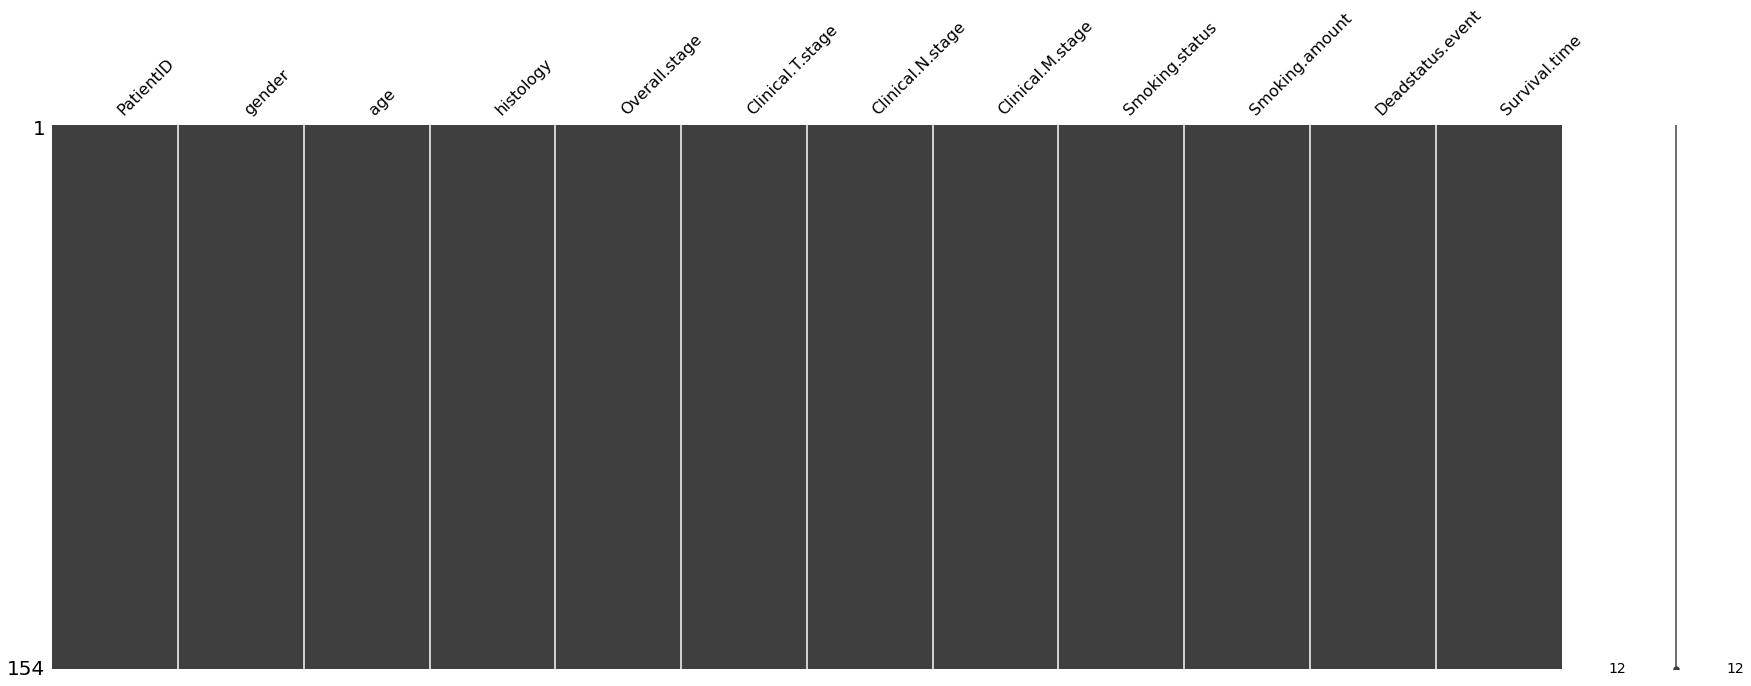

In [17]:
missingno.matrix(df_clinical_train, figsize = (30,10))
#We will use the age feature after filling the NaN values 
df_clinical_train = df_clinical_train.fillna(df_clinical_train.mean())

<AxesSubplot:>

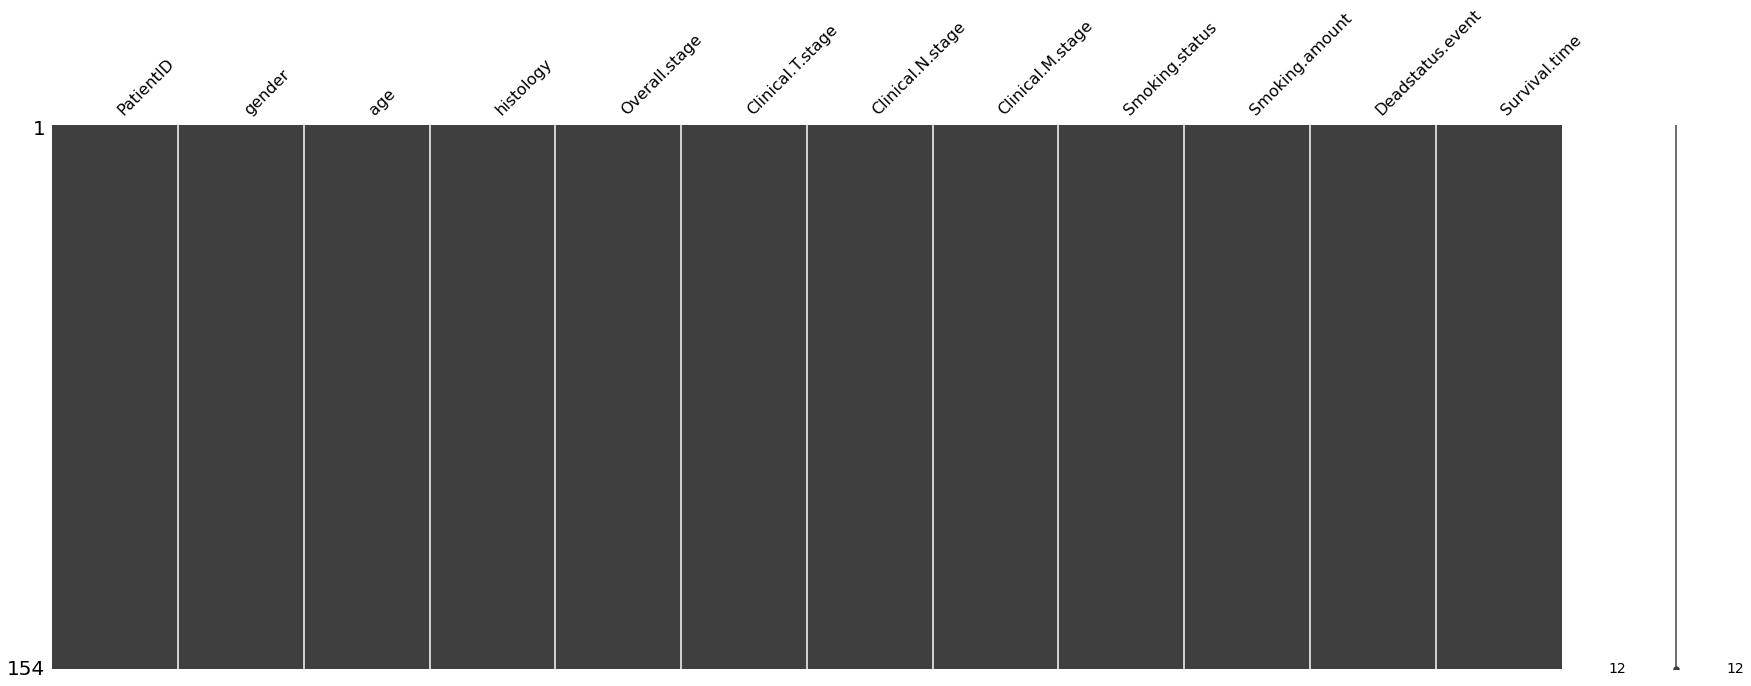

In [18]:
missingno.matrix(df_clinical_train, figsize = (30,10))

<AxesSubplot:title={'center':'Histology Per (%)'}, ylabel='histology'>

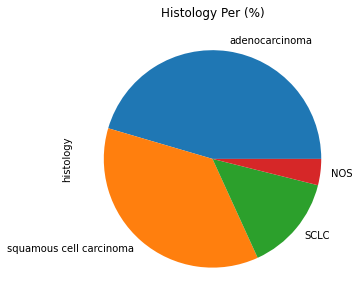

In [19]:
pie_histology = df_clinical_train['histology'].value_counts(normalize=True) * 100
pie_histology.plot.pie(title="Histology Per (%)",figsize=(5,5))

<AxesSubplot:title={'center':'Overall.stage Per (%)'}, ylabel='Overall.stage'>

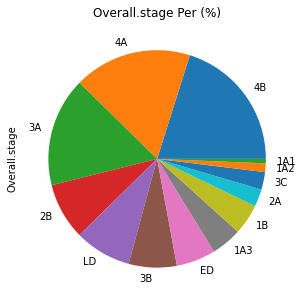

In [20]:
pie_overall_s = df_clinical_train['Overall.stage'].value_counts(normalize=True) * 100
pie_overall_s.plot.pie(title="Overall.stage Per (%)",figsize=(5,5))

<AxesSubplot:title={'center':'Clinical.T.stage Per (%)'}, ylabel='Clinical.T.stage'>

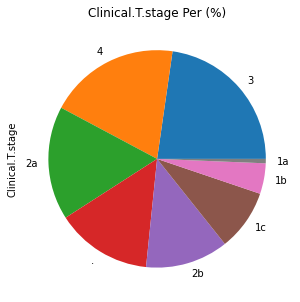

In [21]:
pie_clinical_T = df_clinical_train['Clinical.T.stage'].value_counts(normalize=True) * 100
pie_clinical_T.plot.pie(title="Clinical.T.stage Per (%)",figsize=(5,5))

<AxesSubplot:title={'center':'Clinical.N.stage Per (%)'}, ylabel='Clinical.N.stage'>

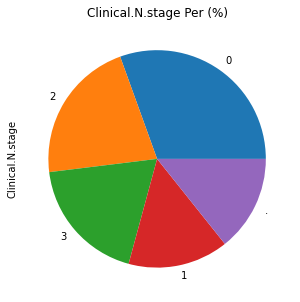

In [22]:
pie_clinical_N = df_clinical_train['Clinical.N.stage'].value_counts(normalize=True) * 100
pie_clinical_N.plot.pie(title="Clinical.N.stage Per (%)",figsize=(5,5))

<AxesSubplot:title={'center':'Clinical.M.stage Per (%)'}, ylabel='Clinical.M.stage'>

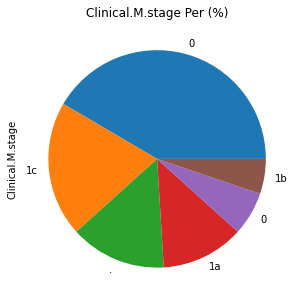

In [23]:
pie_clinical_M = df_clinical_train['Clinical.M.stage'].value_counts(normalize=True) * 100
pie_clinical_M.plot.pie(title="Clinical.M.stage Per (%)",figsize=(5,5))

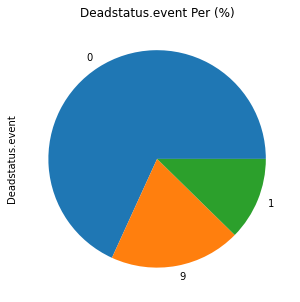

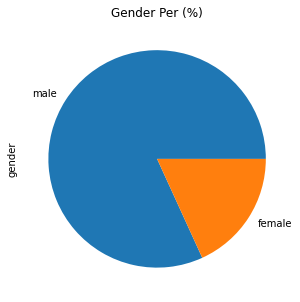

In [24]:
pie_death_status = df_clinical_train['Deadstatus.event'].value_counts(normalize=True) * 100
pie_death_status.plot.pie(title="Deadstatus.event Per (%)",figsize=(5,5))
plt.show()
pie_smoking = df_clinical_train['gender'].value_counts(normalize=True) * 100
pie_smoking.plot.pie(title="Gender Per (%)",figsize=(5,5))
plt.show()

<AxesSubplot:ylabel='Frequency'>

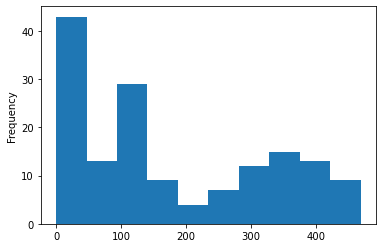

In [25]:
pie_smoking = df_clinical_train['Survival.time']
pie_smoking.plot.hist(bins=10)

<AxesSubplot:ylabel='Frequency'>

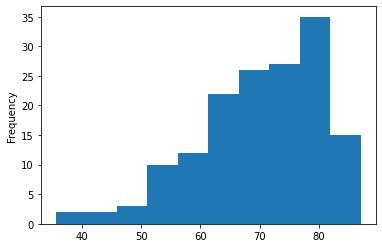

In [26]:
df_clinical_train.age.plot.hist()

In [27]:
encoder = LabelEncoder()
encoder.fit(df_clinical_train["Overall.stage"] )
df_clinical_train["Overall.stage"]= encoder.transform(df_clinical_train["Overall.stage"])

In [28]:
# Prepare unique durations in ascending order
durations = df_clinical_train.sort_values('Survival.time')['Survival.time'].unique()# Initialise the table
columns = ['Survival.time', 'Clinical.T.stage', 'Clinical.N.stage','Deadstatus.event']
km = pd.DataFrame(columns=columns, dtype=np.number)
km = km.append(pd.DataFrame([[0, df_clinical_train.shape[0], 0, 1]], 
                            columns=columns))# Calculate survival probability for each duration
for i, t in enumerate(durations):
    n = np.sum(df_clinical_train['Survival.time']>=t)
    d = np.sum((df_clinical_train['Survival.time']==t) & (df_clinical_train['Deadstatus.event']==1))
    s = (1 - d / n) * km.loc[i, 'Survival.time']
    km = km.append(pd.DataFrame([[t, n, d, s]], 
                                index=[i+1],
                                columns=columns))
km

/tmp/ipykernel_783935/2485954959.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[0, df_clinical_train.shape[0], 0, 1]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and wil

/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km = km.append(pd.DataFrame([[t, n, d, s]],
/tmp/ipykernel_783935/2485954959.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas

,Survival.time,Clinical.T.stage,Clinical.N.stage,Deadstatus.event
0,0.0,154.0,0.0,1.0
1,0.0,154.0,0.0,0.0
2,2.0,153.0,0.0,0.0
3,5.0,152.0,0.0,2.0
4,6.0,151.0,0.0,5.0
...,...,...,...,...
117,443.0,6.0,0.0,436.0
118,448.0,4.0,0.0,443.0
119,449.0,3.0,0.0,448.0
120,463.0,2.0,0.0,449.0


In [29]:
plt.figure(figsize=(8,4))
sns.lineplot(data=km, x='duration', y='survival_probability', 
             drawstyle='steps-post')
plt.ylim(0,1.1) 
plt.title("Kaplan-Meier curve");

ValueError: Could not interpret value `duration` for parameter `x`

<Figure size 576x288 with 0 Axes>

In [30]:
def getSec(s):
    b =int(s[0:2]) *3600 + int(s[2:4])*60 + int(s[4:6])
    return b

In [31]:
for path in fdg_paths:
    num_of_path = path.replace(fdg_dir,"")
    pub_name = fdg_root + "-" + patient_num + "_" + num_of_path
    dataset = pydicom.dcmread(path)
    info_fdg.append(dataset)
    list_fdg.append(dataset.pixel_array*dataset.RescaleSlope)
    
for path in ct_paths:
    num_of_path = path.replace(ct_dir,"")
    pub_name = ct_root + "-" + patient_num + "_" + num_of_path
    dataset = pydicom.dcmread(path)
    info_ct.append(dataset)
    list_ct.append(convert_to_hu(dataset))
    

In [32]:
## Anotation
roi_path = root_path + "AIDATA_ROI_label_PMOD_DICOM(n=400)/" + "ROI_"+ patient_num+".zip"
roi_3D = np.zeros((128,128))
count = 0
with ZipFile(roi_path) as archive:
    for entry in archive.infolist():
        with archive.open(entry) as file:
            count += 1 
            img = np.asarray(Image.open(file).convert("L"))
            roi_3D = np.dstack((img,roi_3D))
roi_3D = np.transpose(roi_3D, (2, 0, 1))
print(np.shape(roi_3D))

(372, 128, 128)


In [33]:
num_of_file = np.shape(fdg_paths)[0] +1
# current layer index start with the first layer 
idx = 0

## load 3D patient:
fdg_3D = resize(np.rot90(np.transpose(np.asarray(list_fdg), (2, 1, 0)),k=1, axes=(0, 2)),np.shape(roi_3D))
ct_3D  = resize(np.asarray(list_ct),np.shape(roi_3D))

#fdg_3D = np.rot90(np.transpose(np.asarray(list_fdg), (2, 1, 0)),k=1, axes=(0, 2))
#ct_3D  = np.asarray(list_ct)
fdg_3D = np.where(roi_3D > 0 , fdg_3D,0)
#ct_3D  = np.where(roi_3D > 0 , ct_3D,0)
list_arr_fdg = fdg_3D.tolist()
list_arr_ct = ct_3D.tolist()

print(np.shape(fdg_3D))
print(np.shape(ct_3D))

(372, 128, 128)
(372, 128, 128)


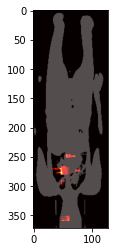

In [34]:
#img_bg = norm(ct_act_3D[20,:,:])
sg = fdg_3D
bg = window_image(ct_3D, -700, 100)
img_sg = map_ax(fdg_3D,1)
lung_bg = window_image(ct_3D, -700, 100)[:,60,:]
fig, ax = plt.subplots()
ax.imshow(lung_bg[:,:], cmap = 'gray')
ax.imshow(img_sg[:,:], cmap = 'hot', alpha=0.7)
plt.show()

In [ ]:
#scope = [50,100,50,200,50,200] #l_top, l_bot, l_left, l_right, l_front, l_back 
showPETCT3D(bg[:,:,:], sg[:,:,:])

In [ ]:
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F
import cv2 as cv
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from ScoreCAM.utils import *
from ScoreCAM.cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from ScoreCAM.utils.visualize import visualize, reverse_normalize
from ScoreCAM.utils.imagenet_labels import label2idx, idx2label

img = cv.merge((norm(img_sg*255.).astype(np.uint8),norm(img_sg*255.).astype(np.uint8),norm(img_sg*255.).astype(np.uint8)))
imshow(img)

# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# convert image to tensor
tensor = preprocess(img)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

model = models.resnet18(pretrained=True)
model.eval()
print(model)

# the target layer you want to visualize
target_layer = model.layer4[1].conv2

# wrapped_model = CAM(model, target_layer)
# wrapped_model =GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=100, stdev_spread=0.01)
#wrapped_model = ScoreCAM(model, target_layer)

cam, idx = wrapped_model(tensor)

print(idx2label[idx])

# visualize only cam
imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
